In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import glob
import matplotlib.pyplot as plt
import seaborn as sns
#import GMM
from statsmodels.sandbox.regression.gmm import GMM, NonlinearIVGMM, LinearIVGMM
import statsmodels.api as sm
#set seaborn graphics
sns.set()
import warnings
warnings.filterwarnings('ignore')

In [2]:
pathdata = os.getcwd()+'/Data'
os.chdir(pathdata)

In [3]:
#read the data
df = pd.read_pickle('unrgdp.pkl')
newdfpc = pd.read_pickle('newdfpc.pkl')

In [4]:
def cumSums(results, first_element = 0):
    cumsumCI = np.zeros((8, 3))
    #first estimate c0
    samplesize = 43
    mean = results.params[first_element] 
    cov = results.cov_params()[first_element,first_element]*samplesize
    upB = mean + 1.96*np.sqrt(cov)/np.sqrt(72)
    lowB = mean - 1.96*np.sqrt(cov)/np.sqrt(72)
    cumsumCI[0, 0] = lowB
    cumsumCI[0, 1] = mean
    cumsumCI[0, 2] = upB
    #we continue for the other coefficients
    for i in range(first_element+1, first_element+8):
        #get the new mean
        mean = mean + results.params[i]
        #add the variance
        cov = cov + results.cov_params()[i,i]*samplesize
        #add the covariances
        for j in range(first_element, i):
            cov = cov + 2*results.cov_params()[j,i]*samplesize
        upB = mean + 1.96*np.sqrt(cov)/np.sqrt(72)
        lowB = mean - 1.96*np.sqrt(cov)/np.sqrt(72)
        cumsumCI[i-first_element, 0] = lowB
        cumsumCI[i-first_element, 1] = mean
        cumsumCI[i-first_element, 2] = upB

    pd.DataFrame(cumsumCI, columns=['LowerB', 'Mean', 'UpperB'])
    plt.plot(pd.DataFrame(cumsumCI, columns=['LowerB', 'Mean', 'UpperB']));
    plt.legend(['LowerB', 'Mean', 'UpperB']);
    plt.title('Cumulative IRs');

# GMM GDP only 

In [60]:
'''
'''
class mpGMM(GMM):
    
    def __init__(self, *args, **kwds):
        # set appropriate counts for moment conditions and parameters
        # TODO: clean up signature
        kwds.setdefault('k_moms', 10)
        kwds.setdefault('k_params', 8)
        super(mpGMM, self).__init__(*args, **kwds)


    def momcond(self, params):
        c0, c1, c2, c3, c4, c5, c6, c7 = params
        endog = self.endog
        exog = self.exog
        #defining variables
        #interaction dummies
        dQ1 = exog[:,0]
        dQ2 = exog[:,1]
        dQ3 = exog[:,2]
        dQ4 = exog[:,3]
        dTY = exog[:,4]
        #endogenous variables
        currentY_gdp = endog[:,0]
        nextY_gdp = endog[:,1]
        twoY_gdp = endog[:,2]
        rolling1_gdp = endog[:,3]
        rolling2_gdp = endog[:,4]       
        #monetary policy shock
        mp = exog[:,5]
        #next year forecasts GDP
        error1 = dQ1*mp*(nextY_gdp-mp*(1/4*c1+1/2*c2+3/4*c3+1*c4+3/4*c5+1/2*c6+1/4*c7)*dQ1)
        error2 = dQ2*mp*(nextY_gdp-mp*(1/4*c0+1/2*c1+3/4*c2+1*c3+3/4*c4+1/2*c5+1/4*c6)*dQ2)
        error3 = dQ3*mp*(nextY_gdp-mp*(1/2*c0+3/4*c1+1*c2+3/4*c3+1/2*c4+1/4*c5)*dQ3)
        error4 = dQ4*mp*(nextY_gdp-mp*(3/4*c0+1*c1+3/4*c2+1/2*c3+1/4*c4)*dQ4)
        #current year forecasts
        error5 = dQ1*mp*(currentY_gdp-mp*(c0+3/4*c1+1/2*c2+1/4*c3)*dQ1)
        error6 = dQ2*mp*(currentY_gdp-mp*(3/4*c0+1/2*c1+1/4*c2)*dQ2)
        error7 = dQ3*mp*(currentY_gdp-mp*(1/2*c0+1/4*c1)*dQ3)
        error8 = dQ4*mp*(currentY_gdp-mp*(1/4*c0)*dQ4)     
        #rolling forecasts
        error9 = mp*(rolling1_gdp-mp*(c2))
        error10 = mp*(rolling2_gdp-mp*(c6))
        g = np.column_stack((error1, error2, error3, error4, error5, error6, 
                            error7, error8, error9, error10))
        return g

#order data
dataols = pd.concat([df, newdfpc], axis=1)
var = 'ConfFactor2'
dataols = dataols.dropna(subset = [var]).iloc[:-1,:]
#time periods
dataols = dataols.loc[(dataols.index>'2002-01-01')&(dataols.index<'2014-01-01')]
#dataols = dataols.loc[dataols.index>'2014-01-01']
#create dummies
dataols['D1'] = (dataols.index.month.isin([1,2])==True)*1
dataols['D2'] = (dataols.index.month.isin([3,4])==True)*1
dataols['D3'] = (dataols.index.month.isin([7,8])==True)*1
dataols['D4'] = (dataols.index.month.isin([10,11])==True)*1
dataols['DTY'] = (dataols['TwoYearDiff_GDP'].isnull()==False)*1
dataols['TwoYearDiff_GDP'] = dataols['TwoYearDiff_GDP'].fillna(value=0)
exog = dataols[['D1', 'D2', 'D3', 'D4', 'DTY', var]]
#exog = dataols[[var]]
endog = dataols[['CurrentYearDiff_GDP', 'OneYearDiff_GDP', 'TwoYearDiff_GDP', 'R1_GDP', 'R2_GDP',
                'CurrentYearDiff_UNR', 'OneYearDiff_UNR', 'R1_UNR', 'R2_UNR']].copy()
#instr = np.asarray(exogt.iloc[:, 4:])
model = mpGMM(endog, exog,  None)
beta0 = np.zeros((1, 8))
res = model.fititer(beta0, maxiter=100, optim_method='nm',   weights_method='cov',
                  wargs={'centered':False})
#,  weights_method='cov',
#                    wargs={'centered':False}
w0 = res[1]
inv_weights = np.linalg.inv(w0)
#inv_weights =inv_weights,
res_gdp = model.fit(beta0, maxiter=10,   inv_weights =inv_weights, optim_method='nm',   weights_method='cov',
                   wargs={'centered':False})
print(res_gdp.summary(yname='GDP forecast diff', xname=['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7']))

Optimization terminated successfully.
         Current function value: 0.060293
         Iterations: 577
         Function evaluations: 840
Optimization terminated successfully.
         Current function value: 0.079403
         Iterations: 816
         Function evaluations: 1211
Optimization terminated successfully.
         Current function value: 0.063479
         Iterations: 584
         Function evaluations: 869
Optimization terminated successfully.
         Current function value: 0.056762
         Iterations: 494
         Function evaluations: 745
Optimization terminated successfully.
         Current function value: 0.051864
         Iterations: 575
         Function evaluations: 868
Optimization terminated successfully.
         Current function value: 0.049021
         Iterations: 847
         Function evaluations: 1258
Optimization terminated successfully.
         Current function value: 0.047453
         Iterations: 673
         Function evaluations: 1006
Optimization term

In [22]:
gdp_sv = res_gdp.params

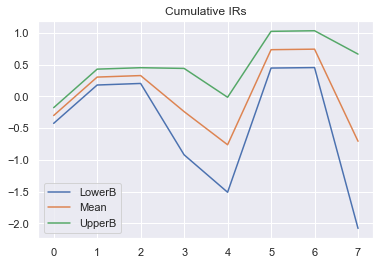

In [61]:
cumSums(res_gdp)

# GMM for unemployment only

In [26]:
'''
'''
class mpGMM(GMM):
    
    def __init__(self, *args, **kwds):
        # set appropriate counts for moment conditions and parameters
        # TODO: clean up signature
        kwds.setdefault('k_moms', 10)
        kwds.setdefault('k_params', 8)
        super(mpGMM, self).__init__(*args, **kwds)


    def momcond(self, params):
        c0_unr, c1_unr, c2_unr, c3_unr, c4_unr, c5_unr, c6_unr, c7_unr  = params
        endog = self.endog
        exog = self.exog
        #defining variables
        #interaction dummies
        dQ1 = exog[:,0]
        dQ2 = exog[:,1]
        dQ3 = exog[:,2]
        dQ4 = exog[:,3]
        dTY = exog[:,4]
        #endogenous variables
        currentY_unr = endog[:,5]
        nextY_unr = endog[:,6]
        rolling1_unr = endog[:,7]
        rolling2_unr = endog[:,8]        
        #monetary policy shock
        mp = exog[:,5]
        #next year forecasts UNR
        error1 = dQ1*mp*(nextY_unr-mp*(1/4*c1_unr+1/2*c2_unr+3/4*c3_unr+1*c4_unr+3/4*c5_unr+1/2*c6_unr+1/4*c7_unr)*dQ1)
        error2 = dQ2*mp*(nextY_unr-mp*(1/4*c0_unr+1/2*c1_unr+3/4*c2_unr+1*c3_unr+3/4*c4_unr+1/2*c5_unr+1/4*c6_unr)*dQ2)
        error3 = dQ3*mp*(nextY_unr-mp*(1/2*c0_unr+3/4*c1_unr+1*c2_unr+3/4*c3_unr+1/2*c4_unr+1/4*c5_unr)*dQ3)
        error4 = dQ4*mp*(nextY_unr-mp*(3/4*c0_unr+1*c1_unr+3/4*c2_unr+1/2*c3_unr+1/4*c4_unr)*dQ4)
        #current year forecasts
        error5 = dQ1*mp*(currentY_unr-mp*(c0_unr+3/4*c1_unr+1/2*c2_unr+1/4*c3_unr)*dQ1)
        error6 = dQ2*mp*(currentY_unr-mp*(3/4*c0_unr+1/2*c1_unr+1/4*c2_unr)*dQ2)
        error7 = dQ3*mp*(currentY_unr-mp*(1/2*c0_unr+1/4*c1_unr)*dQ3)
        error8 = dQ4*mp*(currentY_unr-mp*(1/4*c0_unr)*dQ4)        
        #rolling forecasts
        error9 = mp*(rolling1_unr-mp*(c0_unr+c1_unr+c2_unr+c3_unr))
        error10 = mp*(rolling2_unr-mp*(c4_unr+c5_unr+c6_unr+c7_unr))
        g = np.column_stack((error1, error2, error3, error4, error5, error6, 
                            error7, error8, error9, error10))
        return g

#order data
dataols = pd.concat([df, newdfpc], axis=1)
var = 'ConfFactor2'
dataols = dataols.dropna(subset = [var]).iloc[:-1,:]
#time periods
#dataols = dataols.loc[(dataols.index>'2002-12-01')&(dataols.index<'2014-01-01')]
dataols = dataols.loc[dataols.index>'2014-01-01']
#create dummies
dataols['D1'] = (dataols.index.month.isin([1,2])==True)*1
dataols['D2'] = (dataols.index.month.isin([3,4])==True)*1
dataols['D3'] = (dataols.index.month.isin([7,8])==True)*1
dataols['D4'] = (dataols.index.month.isin([10,11])==True)*1
dataols['DTY'] = (dataols['TwoYearDiff_GDP'].isnull()==False)*1
dataols['TwoYearDiff_GDP'] = dataols['TwoYearDiff_GDP'].fillna(value=0)
exog = dataols[['D1', 'D2', 'D3', 'D4', 'DTY', var]]
#exog = dataols[[var]]
endog = dataols[['CurrentYearDiff_GDP', 'OneYearDiff_GDP', 'TwoYearDiff_GDP', 'R1_GDP', 'R2_GDP',
                'CurrentYearDiff_UNR', 'OneYearDiff_UNR', 'R1_UNR', 'R2_UNR']].copy()
#instr = np.asarray(exogt.iloc[:, 4:])
model = mpGMM(endog, exog,  None)
beta0 = np.zeros((1, 8))
res = model.fititer(beta0, maxiter=100, optim_method='nm',   weights_method='cov',
                  wargs={'centered':True})
#,  weights_method='cov',
#                    wargs={'centered':False}
w0 = res[1]
inv_weights = np.linalg.inv(w0)
#inv_weights =inv_weights,
res_unr = model.fit(beta0, maxiter=10,   inv_weights =inv_weights, optim_method='nm',   weights_method='cov',
                   wargs={'centered':True})
print(res_unr.summary(yname='GDP forecast diff', xname=['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7']))

Optimization terminated successfully.
         Current function value: 0.157433
         Iterations: 978
         Function evaluations: 1447
Optimization terminated successfully.
         Current function value: 0.133319
         Iterations: 812
         Function evaluations: 1245
Optimization terminated successfully.
         Current function value: 0.128615
         Iterations: 82
         Function evaluations: 157
Optimization terminated successfully.
         Current function value: 0.128709
         Iterations: 215
         Function evaluations: 351
Optimization terminated successfully.
         Current function value: 0.128534
         Iterations: 84
         Function evaluations: 163
Optimization terminated successfully.
         Current function value: 0.127350
         Iterations: 618
         Function evaluations: 918
Optimization terminated successfully.
         Current function value: 0.128065
         Iterations: 84
         Function evaluations: 156
Optimization terminat

In [27]:
unr_sv = res_unr.params

In [ ]:
pd.DataFrame(res.cov_params())

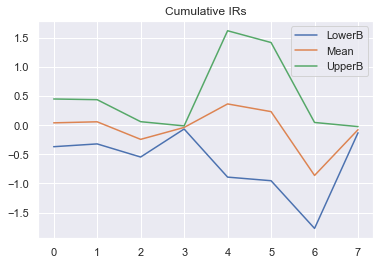

In [28]:
cumSums(res_unr)

# GMM with starting values from the UNR and GDP GMMs combined

In [29]:
gmm_sv = np.concatenate((gdp_sv, unr_sv), axis = 0)
gmm_sv

array([-0.2538305 ,  0.51024156, -0.24460488,  0.04023708, -1.03220397,
        1.95787928, -0.96151902, -0.04092427,  0.04011489,  0.01801392,
       -0.30118041,  0.20418253,  0.40339188, -0.13204042, -1.09435228,
        0.7847555 ])

In [30]:
'''
'''
class mpGMM(GMM):
    
    def __init__(self, *args, **kwds):
        # set appropriate counts for moment conditions and parameters
        # TODO: clean up signature
        kwds.setdefault('k_moms', 20)
        kwds.setdefault('k_params', 16)
        super(mpGMM, self).__init__(*args, **kwds)


    def momcond(self, params):
        c0, c1, c2, c3, c4, c5, c6, c7, c0_unr, c1_unr, c2_unr, c3_unr, c4_unr, c5_unr, c6_unr, c7_unr = params
        endog = self.endog
        exog = self.exog
        #defining variables
        #interaction dummies
        dQ1 = exog[:,0]
        dQ2 = exog[:,1]
        dQ3 = exog[:,2]
        dQ4 = exog[:,3]
        dTY = exog[:,4]
        #endogenous variables
        currentY_gdp = endog[:,0]
        nextY_gdp = endog[:,1]
        twoY_gdp = endog[:,2]
        rolling1_gdp = endog[:,3]
        rolling2_gdp = endog[:,4]
        currentY_unr = endog[:,5]
        nextY_unr = endog[:,6]
        rolling1_unr = endog[:,7]
        rolling2_unr = endog[:,8]        
        #monetary policy shock
        mp = exog[:,5]
        #next year forecasts GDP
        error1 = dQ1*mp*(nextY_gdp-mp*(1/4*c1+1/2*c2+3/4*c3+1*c4+3/4*c5+1/2*c6+1/4*c7)*dQ1)
        error2 = dQ2*mp*(nextY_gdp-mp*(1/4*c0+1/2*c1+3/4*c2+1*c3+3/4*c4+1/2*c5+1/4*c6)*dQ2)
        error3 = dQ3*mp*(nextY_gdp-mp*(1/2*c0+3/4*c1+1*c2+3/4*c3+1/2*c4+1/4*c5)*dQ3)
        error4 = dQ4*mp*(nextY_gdp-mp*(3/4*c0+1*c1+3/4*c2+1/2*c3+1/4*c4)*dQ4)
        #next year forecasts UNR
        error5 = dQ1*mp*(nextY_unr-mp*(1/4*c1_unr+1/2*c2_unr+3/4*c3_unr+1*c4_unr+3/4*c5_unr+1/2*c6_unr+1/4*c7_unr)*dQ1)
        error6 = dQ2*mp*(nextY_unr-mp*(1/4*c0_unr+1/2*c1_unr+3/4*c2_unr+1*c3_unr+3/4*c4_unr+1/2*c5_unr+1/4*c6_unr)*dQ2)
        error7 = dQ3*mp*(nextY_unr-mp*(1/2*c0_unr+3/4*c1_unr+1*c2_unr+3/4*c3_unr+1/2*c4_unr+1/4*c5_unr)*dQ3)
        error8 = dQ4*mp*(nextY_unr-mp*(3/4*c0_unr+1*c1_unr+3/4*c2_unr+1/2*c3_unr+1/4*c4_unr)*dQ4)
        #current year forecasts
        error9 = dQ1*mp*(currentY_gdp-mp*(c0+3/4*c1+1/2*c2+1/4*c3)*dQ1)
        error10 = dQ2*mp*(currentY_gdp-mp*(3/4*c0+1/2*c1+1/4*c2)*dQ2)
        error11 = dQ3*mp*(currentY_gdp-mp*(1/2*c0+1/4*c1)*dQ3)
        error12 = dQ4*mp*(currentY_gdp-mp*(1/4*c0)*dQ4)
        #current year forecasts
        error13 = dQ1*mp*(currentY_unr-mp*(c0_unr+3/4*c1_unr+1/2*c2_unr+1/4*c3_unr)*dQ1)
        error14 = dQ2*mp*(currentY_unr-mp*(3/4*c0_unr+1/2*c1_unr+1/4*c2_unr)*dQ2)
        error15 = dQ3*mp*(currentY_unr-mp*(1/2*c0_unr+1/4*c1_unr)*dQ3)
        error16 = dQ4*mp*(currentY_unr-mp*(1/4*c0_unr)*dQ4)        
        #rolling forecasts
        #r
        error17 = mp*(rolling1_gdp-mp*(c0+c1+c2))
        error18 = mp*(rolling2_gdp-mp*(c3+c4+c5+c6))
        #rolling forecasts
        #r
        error19 = mp*(rolling1_unr-mp*(c0_unr+c1_unr+c2_unr+c3_unr))
        error20 = mp*(rolling2_unr-mp*(c4_unr+c5_unr+c6_unr+c7_unr))
        g = np.column_stack((error1, error2, error3, error4, error5, error6, error7, error8, error9, error10, 
                            error11, error12, error13, error14, error15, error16, error17, error18, error19, error20))
        return g

#order data
dataols = pd.concat([df, newdfpc], axis=1)
var = 'ConfFactor2'
dataols = dataols.dropna(subset = [var]).iloc[:-1,:]
#time periods
dataols = dataols.loc[(dataols.index>'2002-12-01')&(dataols.index<'2014-01-01')]
#dataols = dataols.loc[dataols.index>'2002-01-01']
#create dummies
dataols['D1'] = (dataols.index.month.isin([1,2])==True)*1
dataols['D2'] = (dataols.index.month.isin([3,4])==True)*1
dataols['D3'] = (dataols.index.month.isin([7,8])==True)*1
dataols['D4'] = (dataols.index.month.isin([10,11])==True)*1
dataols['DTY'] = (dataols['TwoYearDiff_GDP'].isnull()==False)*1
dataols['TwoYearDiff_GDP'] = dataols['TwoYearDiff_GDP'].fillna(value=0)
exog = dataols[['D1', 'D2', 'D3', 'D4', 'DTY', var]]
#exog = dataols[[var]]
endog = dataols[['CurrentYearDiff_GDP', 'OneYearDiff_GDP', 'TwoYearDiff_GDP', 'R1_GDP', 'R2_GDP',
                'CurrentYearDiff_UNR', 'OneYearDiff_UNR', 'R1_UNR', 'R2_UNR']].copy()
#instr = np.asarray(exogt.iloc[:, 4:])
model = mpGMM(endog, exog,  None)
beta0 = gmm_sv
res = model.fititer(beta0, maxiter=100, optim_method='nm',   weights_method='cov',
                  wargs={'centered':True})
#,  weights_method='cov',
#                    wargs={'centered':False}
w0 = res[1]
inv_weights = np.linalg.inv(w0)
#inv_weights =inv_weights,
res_all = model.fit(beta0, maxiter=100,   inv_weights =inv_weights, optim_method='nm',   weights_method='cov',
                   wargs={'centered':True})
print(res_all.summary(yname='GDP forecast diff', xname=['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7',
                                                   'c8', 'c9', 'c10', 'c11', 'c12', 'c13', 'c14', 'c15']))

Optimization terminated successfully.
         Current function value: 0.164310
         Iterations: 1654
         Function evaluations: 2217
Optimization terminated successfully.
         Current function value: 0.121191
         Iterations: 157
         Function evaluations: 292
Optimization terminated successfully.
         Current function value: 0.103793
         Iterations: 479
         Function evaluations: 718
Optimization terminated successfully.
         Current function value: 0.103769
         Iterations: 459
         Function evaluations: 721
Optimization terminated successfully.
         Current function value: 0.103817
         Iterations: 255
         Function evaluations: 448
Optimization terminated successfully.
         Current function value: 0.103819
         Iterations: 300
         Function evaluations: 504
Optimization terminated successfully.
         Current function value: 0.103782
         Iterations: 236
         Function evaluations: 423
Optimization termi

Optimization terminated successfully.
         Current function value: 0.165081
         Iterations: 2247
         Function evaluations: 3016
Optimization terminated successfully.
         Current function value: 0.163054
         Iterations: 996
         Function evaluations: 1394
Optimization terminated successfully.
         Current function value: 0.164827
         Iterations: 1499
         Function evaluations: 2069
Optimization terminated successfully.
         Current function value: 0.134898
         Iterations: 1370
         Function evaluations: 1865
Optimization terminated successfully.
         Current function value: 0.135861
         Iterations: 386
         Function evaluations: 611
Optimization terminated successfully.
         Current function value: 0.129485
         Iterations: 2036
         Function evaluations: 2774
Optimization terminated successfully.
         Current function value: 0.125684
         Iterations: 738
         Function evaluations: 1054
Optimizati

In [31]:
#GDP single GMM vs combined
res_gdp.params, res_all.params[0:8]

(array([-0.2538305 ,  0.51024156, -0.24460488,  0.04023708, -1.03220397,
         1.95787928, -0.96151902, -0.04092427]),
 array([-0.15931846,  0.31943796, -0.13237725, -0.00701202, -0.19637985,
         0.36074742, -0.14912926, -0.07072926]))

In [32]:
#UNR single GMM vs combined
res_unr.params, res_all.params[8:]

(array([ 0.04011489,  0.01801392, -0.30118041,  0.20418253,  0.40339188,
        -0.13204042, -1.09435228,  0.7847555 ]),
 array([-0.02333527,  0.02609005, -0.09313612,  0.07553544,  0.0006907 ,
         0.06336037, -0.31573404,  0.23478271]))

## compare J-stats

In [33]:
res_gdp.compare_j(res_all)

(3.8842292205411213, 0.952418492037868, 10)

In [34]:
res_unr.compare_j(res_all)

(2.8690833324567704, 0.9843391685387998, 10)

## Wald test

In [35]:
r_waldtest_gdp = np.array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                    [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                    [0, 0, 1, 0, 0, 0, 0, 0, 0,  0,0, 0, 0, 0, 0, 0],
                    [0, 0, 0, 1, 0, 0, 0, 0, 0, 0,  0, 0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]])
r_waldtest_unr = np.array([[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0, 0, 0, 0,  0, 1, 0, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0,  0, 1, 0, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,  0, 1, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
                    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
                    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]])
r_testsum_gdp = [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]
r_testsum_unr = [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1]

In [36]:
res_all.wald_test(r_waldtest_gdp)

<class 'statsmodels.stats.contrast.ContrastResults'>
<Wald test (chi2): statistic=[[145.81278695]], p-value=1.4631572744675932e-27, df_denom=8>

In [37]:
res_all.wald_test(r_waldtest_unr)

<class 'statsmodels.stats.contrast.ContrastResults'>
<Wald test (chi2): statistic=[[65.15484128]], p-value=4.49752598855671e-11, df_denom=8>

In [38]:
res_all.wald_test(r_testsum_gdp)

<class 'statsmodels.stats.contrast.ContrastResults'>
<Wald test (chi2): statistic=[[0.0044135]], p-value=0.9470321648575453, df_denom=1>

In [39]:
res_all.wald_test(r_testsum_unr)

<class 'statsmodels.stats.contrast.ContrastResults'>
<Wald test (chi2): statistic=[[4.94671199]], p-value=0.02614033809850679, df_denom=1>

## Okun's Law test

In [40]:
rmatrix = np.array([[1, 0, 0, 0, 0, 0, 0, 0, -1.8, 0, 0, 0, 0, 0, 0, 0],
                    [0, 1, 0, 0, 0, 0, 0, 0, 0, -1.8, 0, 0, 0, 0, 0, 0],
                    [0, 0, 1, 0, 0, 0, 0, 0, 0,  0,-1.8, 0, 0, 0, 0, 0],
                    [0, 0, 0, 1, 0, 0, 0, 0, 0, 0,  0,-1.8, 0, 0, 0, 0],
                    [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,  0,-1.8, 0, 0, 0],
                    [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, -1.8, 0, 0],
                    [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, -1.8, 0],
                    [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, -1.8]])
res_all.t_test(rmatrix)

<class 'statsmodels.stats.contrast.ContrastResults'>
                             Test for Constraints                             
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
c0            -0.1173      0.187     -0.626      0.531      -0.485       0.250
c1             0.2725      0.376      0.725      0.468      -0.464       1.009
c2             0.0353      0.239      0.148      0.883      -0.433       0.504
c3            -0.1430      0.253     -0.565      0.572      -0.639       0.353
c4            -0.1976      1.309     -0.151      0.880      -2.763       2.368
c5             0.2467      2.347      0.105      0.916      -4.353       4.846
c6             0.4192      1.266      0.331      0.740      -2.061       2.900
c7            -0.4933      0.490     -1.008      0.314      -1.453       0.466

In [41]:
res_all.t_test(rmatrix)

<class 'statsmodels.stats.contrast.ContrastResults'>
                             Test for Constraints                             
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
c0            -0.1173      0.187     -0.626      0.531      -0.485       0.250
c1             0.2725      0.376      0.725      0.468      -0.464       1.009
c2             0.0353      0.239      0.148      0.883      -0.433       0.504
c3            -0.1430      0.253     -0.565      0.572      -0.639       0.353
c4            -0.1976      1.309     -0.151      0.880      -2.763       2.368
c5             0.2467      2.347      0.105      0.916      -4.353       4.846
c6             0.4192      1.266      0.331      0.740      -2.061       2.900
c7            -0.4933      0.490     -1.008      0.314      -1.453       0.466

### GDP IRFs

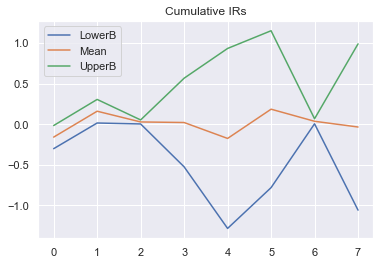

In [42]:
cumsumCI = np.zeros((8, 3))
#first estimate c0
samplesize = 72
mean = res_all.params[0] 
cov = res_all.cov_params()[0,0]*samplesize
upB = mean + 1.96*np.sqrt(cov)/np.sqrt(72)
lowB = mean - 1.96*np.sqrt(cov)/np.sqrt(72)
cumsumCI[0, 0] = lowB
cumsumCI[0, 1] = mean
cumsumCI[0, 2] = upB
#we continue for the other coefficients
for i in range(1, 8):
    #get the new mean
    mean = mean + res_all.params[i]
    #add the variance
    cov = cov + res_all.cov_params()[i,i]*samplesize
    #add the covariances
    for j in range(0, i):
        cov = cov + 2*res_all.cov_params()[j,i]*samplesize
    upB = mean + 1.96*np.sqrt(cov)/np.sqrt(72)
    lowB = mean - 1.96*np.sqrt(cov)/np.sqrt(72)
    cumsumCI[i, 0] = lowB
    cumsumCI[i, 1] = mean
    cumsumCI[i, 2] = upB
    
pd.DataFrame(cumsumCI, columns=['LowerB', 'Mean', 'UpperB'])
plt.plot(pd.DataFrame(cumsumCI, columns=['LowerB', 'Mean', 'UpperB']));
plt.legend(['LowerB', 'Mean', 'UpperB']);
plt.title('Cumulative IRs');

### Unemployment IRFs

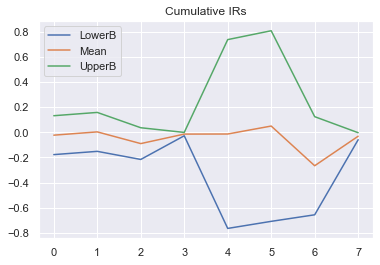

In [43]:
cumsumCI = np.zeros((8, 3))
#first estimate c0
samplesize = 72
mean = res_all.params[8] 
cov = res_all.cov_params()[8,8]*samplesize
upB = mean + 1.96*np.sqrt(cov)/np.sqrt(72)
lowB = mean - 1.96*np.sqrt(cov)/np.sqrt(72)
cumsumCI[0, 0] = lowB
cumsumCI[0, 1] = mean
cumsumCI[0, 2] = upB
#we continue for the other coefficients
for i in range(9, 16):
    #get the new mean
    mean = mean + res_all.params[i]
    #add the variance
    cov = cov + res_all.cov_params()[i,i]*samplesize
    #add the covariances
    for j in range(8, i):
        cov = cov + 2*res_all.cov_params()[j,i]*samplesize
    upB = mean + 1.96*np.sqrt(cov)/np.sqrt(72)
    lowB = mean - 1.96*np.sqrt(cov)/np.sqrt(72)
    cumsumCI[i-8, 0] = lowB
    cumsumCI[i-8, 1] = mean
    cumsumCI[i-8, 2] = upB
    
pd.DataFrame(cumsumCI, columns=['LowerB', 'Mean', 'UpperB'])
plt.plot(pd.DataFrame(cumsumCI, columns=['LowerB', 'Mean', 'UpperB']));
plt.legend(['LowerB', 'Mean', 'UpperB']);
plt.title('Cumulative IRs');

# GMM GDP with starting values from combined

In [44]:
'''
'''
class mpGMM(GMM):
    
    def __init__(self, *args, **kwds):
        # set appropriate counts for moment conditions and parameters
        # TODO: clean up signature
        kwds.setdefault('k_moms', 10)
        kwds.setdefault('k_params', 8)
        super(mpGMM, self).__init__(*args, **kwds)


    def momcond(self, params):
        c0, c1, c2, c3, c4, c5, c6, c7  = params
        endog = self.endog
        exog = self.exog
        #defining variables
        #interaction dummies
        dQ1 = exog[:,0]
        dQ2 = exog[:,1]
        dQ3 = exog[:,2]
        dQ4 = exog[:,3]
        dTY = exog[:,4]
        #endogenous variables
        currentY_gdp = endog[:,0]
        nextY_gdp = endog[:,1]
        twoY_gdp = endog[:,2]
        rolling1_gdp = endog[:,3]
        rolling2_gdp = endog[:,4]       
        #monetary policy shock
        mp = exog[:,5]
        #next year forecasts GDP
        error1 = dQ1*mp*(nextY_gdp-mp*(1/4*c1+1/2*c2+3/4*c3+1*c4+3/4*c5+1/2*c6+1/4*c7)*dQ1)
        error2 = dQ2*mp*(nextY_gdp-mp*(1/4*c0+1/2*c1+3/4*c2+1*c3+3/4*c4+1/2*c5+1/4*c6)*dQ2)
        error3 = dQ3*mp*(nextY_gdp-mp*(1/2*c0+3/4*c1+1*c2+3/4*c3+1/2*c4+1/4*c5)*dQ3)
        error4 = dQ4*mp*(nextY_gdp-mp*(3/4*c0+1*c1+3/4*c2+1/2*c3+1/4*c4)*dQ4)
        #current year forecasts
        error5 = dQ1*mp*(currentY_gdp-mp*(c0+3/4*c1+1/2*c2+1/4*c3)*dQ1)
        error6 = dQ2*mp*(currentY_gdp-mp*(3/4*c0+1/2*c1+1/4*c2)*dQ2)
        error7 = dQ3*mp*(currentY_gdp-mp*(1/2*c0+1/4*c1)*dQ3)
        error8 = dQ4*mp*(currentY_gdp-mp*(1/4*c0)*dQ4)     
        #rolling forecasts
        error9 = mp*(rolling1_gdp-mp*(c2))
        error10 = mp*(rolling2_gdp-mp*(c6))
        g = np.column_stack((error1, error2, error3, error4, error5, error6, 
                            error7, error8, error9, error10))
        return g

#order data
dataols = pd.concat([df, newdfpc], axis=1)
var = 'ConfFactor2'
dataols = dataols.dropna(subset = [var]).iloc[:-1,:]
#time periods
dataols = dataols.loc[(dataols.index>'2001-12-01')&(dataols.index<'2015-01-01')]
#dataols = dataols.loc[dataols.index>'2002-01-01']
#create dummies
dataols['D1'] = (dataols.index.month.isin([1,2])==True)*1
dataols['D2'] = (dataols.index.month.isin([3,4])==True)*1
dataols['D3'] = (dataols.index.month.isin([7,8])==True)*1
dataols['D4'] = (dataols.index.month.isin([10,11])==True)*1
dataols['DTY'] = (dataols['TwoYearDiff_GDP'].isnull()==False)*1
dataols['TwoYearDiff_GDP'] = dataols['TwoYearDiff_GDP'].fillna(value=0)
exog = dataols[['D1', 'D2', 'D3', 'D4', 'DTY', var]]
#exog = dataols[[var]]
endog = dataols[['CurrentYearDiff_GDP', 'OneYearDiff_GDP', 'TwoYearDiff_GDP', 'R1_GDP', 'R2_GDP',
                'CurrentYearDiff_UNR', 'OneYearDiff_UNR', 'R1_UNR', 'R2_UNR']].copy()
#instr = np.asarray(exogt.iloc[:, 4:])
model = mpGMM(endog, exog,  None)
beta0 = res_all.params[:8]
res = model.fititer(beta0, maxiter=100, optim_method='nm',   weights_method='cov',
                  wargs={'centered':True})
#,  weights_method='cov',
#                    wargs={'centered':False}
w0 = res[1]
inv_weights = np.linalg.inv(w0)
#inv_weights =inv_weights,
res_gdp1 = model.fit(beta0, maxiter=10,   inv_weights =inv_weights, optim_method='nm',   weights_method='cov',
                   wargs={'centered':True})
print(res_gdp1.summary(yname='GDP forecast diff', xname=['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7']))

Optimization terminated successfully.
         Current function value: 0.023901
         Iterations: 1008
         Function evaluations: 1487
Optimization terminated successfully.
         Current function value: 0.054739
         Iterations: 643
         Function evaluations: 964
Optimization terminated successfully.
         Current function value: 0.067034
         Iterations: 963
         Function evaluations: 1428
Optimization terminated successfully.
         Current function value: 0.063158
         Iterations: 948
         Function evaluations: 1405
Optimization terminated successfully.
         Current function value: 0.052951
         Iterations: 524
         Function evaluations: 811
Optimization terminated successfully.
         Current function value: 0.045113
         Iterations: 942
         Function evaluations: 1390
Optimization terminated successfully.
         Current function value: 0.041812
         Iterations: 319
         Function evaluations: 502
Optimization te

In [45]:
res_gdp1.params, res_gdp.params, res_all.params[:8]

(array([-0.27998824,  0.56289715,  0.0228824 , -0.56185563, -0.41061072,
         1.34475198,  0.00811469, -1.42009467]),
 array([-0.2538305 ,  0.51024156, -0.24460488,  0.04023708, -1.03220397,
         1.95787928, -0.96151902, -0.04092427]),
 array([-0.15931846,  0.31943796, -0.13237725, -0.00701202, -0.19637985,
         0.36074742, -0.14912926, -0.07072926]))

In [46]:
res_all.jtest()

(5.295716121902442, 0.2582782212310662, 4)

# UNR with starting values from the combined GMM

In [47]:
'''
'''
class mpGMM(GMM):
    
    def __init__(self, *args, **kwds):
        # set appropriate counts for moment conditions and parameters
        # TODO: clean up signature
        kwds.setdefault('k_moms', 10)
        kwds.setdefault('k_params', 8)
        super(mpGMM, self).__init__(*args, **kwds)


    def momcond(self, params):
        c0_unr, c1_unr, c2_unr, c3_unr, c4_unr, c5_unr, c6_unr, c7_unr  = params
        endog = self.endog
        exog = self.exog
        #defining variables
        #interaction dummies
        dQ1 = exog[:,0]
        dQ2 = exog[:,1]
        dQ3 = exog[:,2]
        dQ4 = exog[:,3]
        dTY = exog[:,4]
        #endogenous variables
        currentY_unr = endog[:,5]
        nextY_unr = endog[:,6]
        rolling1_unr = endog[:,7]
        rolling2_unr = endog[:,8]        
        #monetary policy shock
        mp = exog[:,5]
        #next year forecasts UNR
        error1 = dQ1*mp*(nextY_unr-mp*(1/4*c1_unr+1/2*c2_unr+3/4*c3_unr+1*c4_unr+3/4*c5_unr+1/2*c6_unr+1/4*c7_unr)*dQ1)
        error2 = dQ2*mp*(nextY_unr-mp*(1/4*c0_unr+1/2*c1_unr+3/4*c2_unr+1*c3_unr+3/4*c4_unr+1/2*c5_unr+1/4*c6_unr)*dQ2)
        error3 = dQ3*mp*(nextY_unr-mp*(1/2*c0_unr+3/4*c1_unr+1*c2_unr+3/4*c3_unr+1/2*c4_unr+1/4*c5_unr)*dQ3)
        error4 = dQ4*mp*(nextY_unr-mp*(3/4*c0_unr+1*c1_unr+3/4*c2_unr+1/2*c3_unr+1/4*c4_unr)*dQ4)
        #current year forecasts
        error5 = dQ1*mp*(currentY_unr-mp*(c0_unr+3/4*c1_unr+1/2*c2_unr+1/4*c3_unr)*dQ1)
        error6 = dQ2*mp*(currentY_unr-mp*(3/4*c0_unr+1/2*c1_unr+1/4*c2_unr)*dQ2)
        error7 = dQ3*mp*(currentY_unr-mp*(1/2*c0_unr+1/4*c1_unr)*dQ3)
        error8 = dQ4*mp*(currentY_unr-mp*(1/4*c0_unr)*dQ4)        
        #rolling forecasts
        error9 = mp*(rolling1_unr-mp*(c2_unr))
        error10 = mp*(rolling2_unr-mp*(c6_unr))
        g = np.column_stack((error1, error2, error3, error4, error5, error6, 
                            error7, error8, error9, error10))
        return g

#order data
dataols = pd.concat([df, newdfpc], axis=1)
var = 'ConfFactor2'
dataols = dataols.dropna(subset = [var]).iloc[:-1,:]
#time periods
dataols = dataols.loc[(dataols.index>'2001-12-01')&(dataols.index<'2015-01-01')]
#dataols = dataols.loc[dataols.index>'2002-01-01']
#create dummies
dataols['D1'] = (dataols.index.month.isin([1,2])==True)*1
dataols['D2'] = (dataols.index.month.isin([3,4])==True)*1
dataols['D3'] = (dataols.index.month.isin([7,8])==True)*1
dataols['D4'] = (dataols.index.month.isin([10,11])==True)*1
dataols['DTY'] = (dataols['TwoYearDiff_GDP'].isnull()==False)*1
dataols['TwoYearDiff_GDP'] = dataols['TwoYearDiff_GDP'].fillna(value=0)
exog = dataols[['D1', 'D2', 'D3', 'D4', 'DTY', var]]
#exog = dataols[[var]]
endog = dataols[['CurrentYearDiff_GDP', 'OneYearDiff_GDP', 'TwoYearDiff_GDP', 'R1_GDP', 'R2_GDP',
                'CurrentYearDiff_UNR', 'OneYearDiff_UNR', 'R1_UNR', 'R2_UNR']].copy()
#instr = np.asarray(exogt.iloc[:, 4:])
model = mpGMM(endog, exog,  None)
beta0 = res_all.params[8:]
res = model.fititer(beta0, maxiter=100, optim_method='nm',   weights_method='cov',
                  wargs={'centered':True})
#,  weights_method='cov',
#                    wargs={'centered':False}
w0 = res[1]
inv_weights = np.linalg.inv(w0)
#inv_weights =inv_weights,
res_unr1 = model.fit(beta0, maxiter=10,   inv_weights =inv_weights, optim_method='nm',   weights_method='cov',
                   wargs={'centered':True})
print(res_unr1.summary(yname='GDP forecast diff', xname=['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7']))

Optimization terminated successfully.
         Current function value: 0.017772
         Iterations: 459
         Function evaluations: 691
Optimization terminated successfully.
         Current function value: 0.045581
         Iterations: 682
         Function evaluations: 1019
Optimization terminated successfully.
         Current function value: 0.046039
         Iterations: 580
         Function evaluations: 871
Optimization terminated successfully.
         Current function value: 0.043744
         Iterations: 552
         Function evaluations: 838
Optimization terminated successfully.
         Current function value: 0.007769
         Iterations: 969
         Function evaluations: 1432
Optimization terminated successfully.
         Current function value: 0.008618
         Iterations: 235
         Function evaluations: 386
Optimization terminated successfully.
         Current function value: 0.008532
         Iterations: 606
         Function evaluations: 925
Optimization termi

In [48]:
res_unr1.params, res_unr.params, res_all.params[8:]

(array([ 0.07241116, -0.16362686, -0.01187018,  0.08247819,  0.50444479,
        -0.91106113, -0.01319456,  0.54921875]),
 array([ 0.04011489,  0.01801392, -0.30118041,  0.20418253,  0.40339188,
        -0.13204042, -1.09435228,  0.7847555 ]),
 array([-0.02333527,  0.02609005, -0.09313612,  0.07553544,  0.0006907 ,
         0.06336037, -0.31573404,  0.23478271]))

In [49]:
res_gdp.compare_j(res_gdp1)

(-0.6290455799983818, nan, 0)

In [50]:
res_unr.compare_j(res_unr1)

(1.990163508578348, nan, 0)